# Лабораторная работа №1 
## Извлечение признаков из текстовых данных

## Импорты

In [1]:
import re
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from num2words import num2words
import pandas as pd
from pymorphy3 import MorphAnalyzer
from sklearn.decomposition import PCA

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Azerty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Azerty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Azerty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Загрузка датасета

In [52]:
petitions = pd.read_csv("../../datasets/lab1-feature_extraction/petitions.csv")
petitions.head()

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство


In [53]:
df_corpus = petitions["public_petition_text"]
df_corpus.name = "corpus"
display(df_corpus[:5], df_corpus.shape)

0                                       снег на дороге
1                  очистить кабельный киоск от рекламы
2    Просим убрать все деревья и кустарники, которы...
3    Неудовлетворительное состояние парадной - надп...
4                                             Граффити
Name: corpus, dtype: object

(59889,)

## Предобработка

In [54]:
df_corpus.duplicated().sum()

np.int64(16749)

In [55]:
df_corpus = df_corpus.drop_duplicates()
df_corpus.shape

(43140,)

In [56]:
def replace_number(number) -> str:
    return " " + num2words(number.group(0), lang="ru") + " "


def replace_several_words(text: str, replacements: dict[str, str]) -> str:
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)
    return text


def preprocess(text: str):
    # ссылки
    pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    text = re.sub(pattern, "", text)
    # числа
    text = re.sub(r"\d+", replace_number, text)
    # замена слов
    replacements = {
        r"\bд\b": "дом",
        r"\bкв\b": "квартира",
        r"\bул\b": "улица",
        r"\bк\b": "квартира",
    }
    text = replace_several_words(text, replacements)
    # удалить все символы кроме слов
    text = re.sub(r"[_\W]+", " ", text)
    # удалить все слова кроме русских
    text = re.sub(r"[^а-яА-ЯёЁ\s]", "", text)
    return text

In [57]:
preprocessed_corpus = df_corpus.apply(preprocess)
preprocessed_corpus.head()

0                                       снег на дороге
1                  очистить кабельный киоск от рекламы
2    Просим убрать все деревья и кустарники которые...
3    Неудовлетворительное состояние парадной надпис...
4                                             Граффити
Name: corpus, dtype: object

## Токенизация

In [58]:
def tokenize(text: str) -> list[str]:
    return word_tokenize(text, language="russian")

In [59]:
tokenized_corpus = preprocessed_corpus.apply(tokenize)
tokenized_corpus[:5]

0                                   [снег, на, дороге]
1            [очистить, кабельный, киоск, от, рекламы]
2    [Просим, убрать, все, деревья, и, кустарники, ...
3    [Неудовлетворительное, состояние, парадной, на...
4                                           [Граффити]
Name: corpus, dtype: object

## Нормализация

In [60]:
morph = MorphAnalyzer(lang="ru")
threshold = 0.45


def normalize(doc: list[str]) -> list[str]:
    changed_text = []
    for word in doc:
        parse = morph.parse(word)[0]
        if parse.score >= threshold:
            changed_text.append(parse.normal_form)
    return changed_text

In [61]:
normalized_corpus = tokenized_corpus.apply(normalize)
normalized_corpus[:5]

0                                   [снег, на, дорога]
1            [очистить, кабельный, киоск, от, реклама]
2    [просить, убрать, всё, дерево, и, кустарник, к...
3          [неудовлетворительный, состояние, на, этаж]
4                                                   []
Name: corpus, dtype: object

## Стоп-слова

In [62]:
stop_words = stopwords.words("russian")


def delete_stopwords(text: list[str]) -> list[str]:
    return [word for word in text if word not in stop_words]

In [63]:
filtered_corpus = normalized_corpus.apply(delete_stopwords)
filtered_corpus[:5]

0                                       [снег, дорога]
1                [очистить, кабельный, киоск, реклама]
2    [просить, убрать, всё, дерево, кустарник, кото...
3              [неудовлетворительный, состояние, этаж]
4                                                   []
Name: corpus, dtype: object

In [64]:
corpus = filtered_corpus[filtered_corpus.apply(lambda doc: len(doc) >= 5)]
display(corpus[:10], len(corpus))

2     [просить, убрать, всё, дерево, кустарник, кото...
5     [необходимо, проверить, законность, установка,...
6     [уборка, производиться, лестница, очень, грязн...
8     [отсутствовать, освещение, площадка, шесть, се...
9     [делать, благоустройство, никто, убирать, мусо...
15    [пожалуйста, удалить, бетонный, арматура, газо...
17    [ланский, дом, двенадцать, квартира, парадный,...
18           [кривой, висеть, просьба, поправить, этаж]
19    [плохой, уборка, улица, мусор, тротуар, газон,...
23    [демонтаж, рекламный, вывеска, фасад, образова...
Name: corpus, dtype: object

29679

In [65]:
# corpus.apply(" ".join).to_csv("../../datasets/lab1-feature_extraction/corpus.csv", index=False)

## Матрица контекстных эмбеддингов

In [66]:
vocabulary = sorted(set([word for doc in corpus for word in doc]))
display(vocabulary[:10], len(vocabulary))

['аа',
 'ааш',
 'аба',
 'абажур',
 'абз',
 'абзац',
 'абонентский',
 'абп',
 'абразив',
 'абразивный']

13505

In [67]:
N = len(vocabulary)
context_embeddings = pd.DataFrame(
    data=np.zeros((N, N)),
    index=vocabulary,
    columns=vocabulary,
    dtype=np.int16
)
context_embeddings

,аа,ааш,аба,абажур,абз,абзац,абонентский,абп,абразив,абразивный,...,ясно,ясный,яхтенный,ячейка,ящик,ёлка,ёлочка,ёлочный,ёмкость,ёх
аа,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ааш,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
аба,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
абажур,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
абз,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ёлка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ёлочка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ёлочный,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ёмкость,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
for doc in tqdm(corpus):
    for i in range(len(doc) - 2):
        main_word = doc[i]
        for word in doc[i + 1 : i + 3]:
            context_embeddings.loc[main_word, word] += 1
            context_embeddings.loc[word, main_word] += 1

# context_embeddings.to_csv("../../datasets/lab1-feature_extraction/embeddings.csv")

  0%|          | 0/29679 [00:00<?, ?it/s]

In [69]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(context_embeddings)
w2v = pd.DataFrame(pca_embeddings, index=context_embeddings.index)
w2v.index.name = "word"
w2v

,0,1
word,,
аа,-5.251284,2.832252
ааш,-5.246583,2.369324
аба,-5.463699,2.696263
абажур,-5.504235,2.487352
абз,-4.865602,2.937585
...,...,...
ёлка,-3.701815,-0.015286
ёлочка,-5.516117,2.544450
ёлочный,-5.527348,2.570741


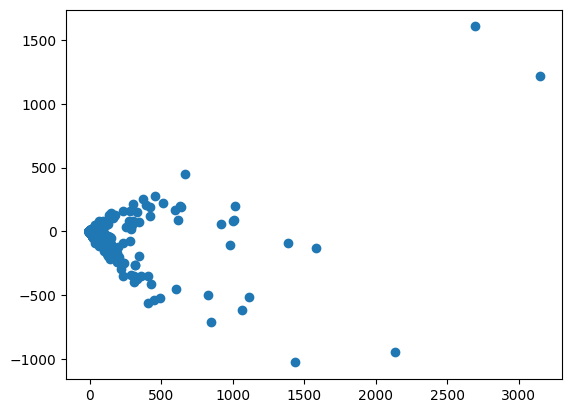

In [93]:
plt.scatter(x=w2v[0], y=w2v[1])